## 1. SEGMENTA LOS DÍGITOS EN CADA IMAGEN (MANUALMENTE)

In [2]:
!pip install cv2
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en escala de grises
ruta = "Geiger/ocr_input_5148s.png"
img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

# Umbral adaptativo + binarización
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Eliminar ruido con apertura morfológica
kernel = np.ones((2, 2), np.uint8)
limpio = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Invertir y dilatar para mejorar el trazo
invertido = cv2.bitwise_not(limpio)
procesado = cv2.dilate(invertido, kernel, iterations=1)

# Volver a invertir para mantener fondo blanco y texto negro
procesado = cv2.bitwise_not(procesado)

# Encontrar contornos
contornos, _ = cv2.findContours(procesado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenar los contornos de izquierda a derecha
contornos = sorted(contornos, key=lambda c: cv2.boundingRect(c)[0])

# Recortar cada dígito, redimensionar a 28x28 y almacenar
digitos = []
for c in contornos:
    x, y, w, h = cv2.boundingRect(c)
    if h > 15 and w > 5:  # Filtro para evitar ruido
        roi = procesado[y:y+h, x:x+w]
        digit = cv2.resize(roi, (28, 28))
        digitos.append(digit)

# Mostrar los dígitos extraídos
plt.figure(figsize=(10, 3))
for i, d in enumerate(digitos):
    plt.subplot(1, len(digitos), i+1)
    plt.imshow(d, cmap='gray')
    plt.axis('off')
plt.suptitle("Dígitos segmentados")
plt.show()

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

ModuleNotFoundError: No module named 'cv2'

## 2. GENERA LAS IMAGENES DE LOS NÚMEROS SEGMENTADOS CON LAS ETIQUETAS DEL FICHERO Lecturas_geiger.CSV

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Función para segmentar una imagen
# -------------------------------
def segmentar_digitos(ruta_imagen):
    img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    limpio = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    procesado = cv2.bitwise_not(cv2.dilate(cv2.bitwise_not(limpio), kernel, iterations=1))
    contornos, _ = cv2.findContours(procesado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key=lambda c: cv2.boundingRect(c)[0])
    digitos = []
    for c in contornos:
        x, y, w, h = cv2.boundingRect(c)
        if h > 15 and w > 5:
            roi = procesado[y:y+h, x:x+w]
            digit = cv2.resize(roi, (28, 28))
            digitos.append(digit)
    return digitos

# -------------------------------
# Cargar el CSV y construir la lista de rutas y etiquetas
# -------------------------------
df = pd.read_csv('Lecturas_geiger.csv')

datos = []
for _, fila in df.iterrows():
    if pd.isna(fila['Tiempo']) or pd.isna(fila['Valor']):
        print(f"⚠️ Fila incompleta o vacía. Tiempo={fila['Tiempo']}, Valor={fila['Valor']}")
        continue
    try:
        numero = str(int(float(fila['Tiempo'])))            # Eliminar decimales de 'Tiempo'
        valor_entero = int(float(fila['Valor']))            # Convertir a entero
        valor = str(valor_entero).ljust(4, '0')             # Rellenar con ceros a la derecha si hace falta
    except ValueError:
        print(f"⚠️ Error de conversión en fila: {fila}")
        continue

    ruta = f'Geiger/ocr_input_{numero}s.png'
    digitos = [int(d) for d in valor]
    datos.append((ruta, digitos))

# -------------------------------
# Guardar cada dígito en su carpeta correspondiente
# -------------------------------
output_dir = Path('Geiger/dataset/train')
output_dir.mkdir(parents=True, exist_ok=True)

for ruta, etiquetas in datos:
    digitos = segmentar_digitos(ruta)

    if len(digitos) != len(etiquetas):
        print(f"⚠️ Atención: En {ruta}, se detectaron {len(digitos)} dígitos pero hay {len(etiquetas)} etiquetas.")
        continue

    for i, (digit, label) in enumerate(zip(digitos, etiquetas)):
        clase_dir = output_dir / str(label)
        clase_dir.mkdir(parents=True, exist_ok=True)
        filename = clase_dir / f'{Path(ruta).stem}_d{i}_{np.random.randint(10000)}.png'
        cv2.imwrite(str(filename), digit)

    print(f"✅ {ruta} procesado y guardado.")


✅ Geiger/ocr_input_250s.png procesado y guardado.
✅ Geiger/ocr_input_251s.png procesado y guardado.
✅ Geiger/ocr_input_252s.png procesado y guardado.
✅ Geiger/ocr_input_253s.png procesado y guardado.
✅ Geiger/ocr_input_254s.png procesado y guardado.
✅ Geiger/ocr_input_255s.png procesado y guardado.
✅ Geiger/ocr_input_256s.png procesado y guardado.
✅ Geiger/ocr_input_257s.png procesado y guardado.
✅ Geiger/ocr_input_258s.png procesado y guardado.
✅ Geiger/ocr_input_259s.png procesado y guardado.
✅ Geiger/ocr_input_260s.png procesado y guardado.
✅ Geiger/ocr_input_261s.png procesado y guardado.
✅ Geiger/ocr_input_262s.png procesado y guardado.
✅ Geiger/ocr_input_263s.png procesado y guardado.
✅ Geiger/ocr_input_264s.png procesado y guardado.
✅ Geiger/ocr_input_265s.png procesado y guardado.
✅ Geiger/ocr_input_266s.png procesado y guardado.
✅ Geiger/ocr_input_267s.png procesado y guardado.
✅ Geiger/ocr_input_268s.png procesado y guardado.
✅ Geiger/ocr_input_269s.png procesado y guardado.


## 3.ENTRENA EL MODELO PARTIENDO DE LAS IMAGENES ETIQUETADAS ANTERIORES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# -------------------------------
# 1. Cargar el dataset desde las carpetas
# -------------------------------
batch_size = 32
img_size = (28, 28)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Geiger/dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=img_size,
    color_mode="grayscale",
    shuffle=True,
    seed=123,
    batch_size=batch_size
)

# Normalizar imágenes: escala de 0-255 a 0-1
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# -------------------------------
# 2. Definir el modelo CNN
# -------------------------------
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases (0 a 9)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -------------------------------
# 3. Entrenar el modelo
# -------------------------------
model.fit(train_ds, epochs=10)

# -------------------------------
# 4. Guardar el modelo entrenado
# -------------------------------
model.save("modelo_digitos.keras")
print("✅ Modelo guardado como modelo_digitos.keras")

Found 3496 files belonging to 10 classes.
Epoch 1/10


C:\Users\xosec\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7697 - loss: 0.8285
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9888 - loss: 0.0622
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9906 - loss: 0.0524
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9903 - loss: 0.0408
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9905 - loss: 0.0375
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9922 - loss: 0.0350
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9909 - loss: 0.0357
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9917 - loss: 0.0283
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9933 - loss: 0.0221
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9928 - loss: 0.0296
✅ Modelo guardado como modelo_digitos.keras


## 4. COMPROBAMOS QUE EL MODELO ENTRENADO DETECTA LOS NÚMEROS CORRECAMENTE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
✅ Número detectado: 8247


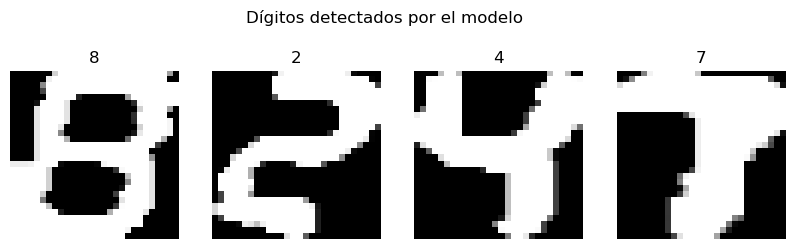

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
import matplotlib.pyplot as plt

# -------------------------------
# 1. Función para segmentar los dígitos
# -------------------------------
def segmentar_digitos(ruta_imagen):
    img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    limpio = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    procesado = cv2.bitwise_not(cv2.dilate(cv2.bitwise_not(limpio), kernel, iterations=1))
    contornos, _ = cv2.findContours(procesado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key=lambda c: cv2.boundingRect(c)[0])
    digitos = []
    for c in contornos:
        x, y, w, h = cv2.boundingRect(c)
        if h > 15 and w > 5:
            roi = procesado[y:y+h, x:x+w]
            digit = cv2.resize(roi, (28, 28))
            digit = digit.astype("float32") / 255.0
            digitos.append(digit.reshape(28, 28, 1))
    return np.array(digitos)

# -------------------------------
# 2. Cargar modelo entrenado
# -------------------------------
modelo = load_model("modelo_digitos.keras")

# -------------------------------
# 3. Cargar y procesar imagen
# -------------------------------
ruta = "Geiger/ocr_input_5007s.png"  # Cambia por tu imagen
digitos_segmentados = segmentar_digitos(ruta)

# -------------------------------
# 4. Predecir los dígitos
# -------------------------------
predicciones = modelo.predict(digitos_segmentados)
numeros = [np.argmax(p) for p in predicciones]

# Mostrar resultados
print("✅ Número detectado:", "".join(map(str, numeros)))

# Mostrar visualmente
plt.figure(figsize=(10, 3))
for i, d in enumerate(digitos_segmentados):
    plt.subplot(1, len(digitos_segmentados), i+1)
    plt.imshow(d.squeeze(), cmap='gray')
    plt.title(numeros[i])
    plt.axis('off')
plt.suptitle("Dígitos detectados por el modelo")
plt.show()

## 5.GENERA UN FICHERO CSV CON LA EJECUCIÓN DEL MODELO SOBRE TODOS LOS FICHEROS DE IMAGEN (PROCESA EN BLOQUES DE 1000 IMAGENES)

In [ ]:
# Diviendo ejecución en bloques de 1000 ficheros, que se cuelga con facilidad

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
import pandas as pd
import re

# -------------------------------
# Cargar el modelo entrenado
# -------------------------------
modelo = load_model("modelo_digitos.keras")

# -------------------------------
# Función para segmentar los dígitos
# -------------------------------
def segmentar_digitos(ruta_imagen):
    img = cv2.imread(str(ruta_imagen), cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    limpio = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    procesado = cv2.bitwise_not(cv2.dilate(cv2.bitwise_not(limpio), kernel, iterations=1))
    contornos, _ = cv2.findContours(procesado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key=lambda c: cv2.boundingRect(c)[0])
    digitos = []
    for c in contornos:
        x, y, w, h = cv2.boundingRect(c)
        if h > 15 and w > 5:
            roi = procesado[y:y+h, x:x+w]
            digit = cv2.resize(roi, (28, 28)).astype("float32") / 255.0
            digitos.append(digit.reshape(28, 28, 1))
    return np.array(digitos)

# -------------------------------
# Procesar archivos en bloques
# -------------------------------
carpeta = Path("Geiger")
archivos = list(carpeta.glob("ocr_input_*s.png"))
total_archivos = len(archivos)
bloque_tamano = 1000

bloques = [archivos[i:i+bloque_tamano] for i in range(0, total_archivos, bloque_tamano)]

df_final = pd.DataFrame()

for idx, bloque in enumerate(bloques, start=1):
    print(f"\n🧩 Procesando bloque {idx}/{len(bloques)} con {len(bloque)} archivos...")
    resultados = []

    for i, imagen_path in enumerate(bloque, start=1):
        print(f"  [{i}/{len(bloque)}] {imagen_path.name}")

        match = re.search(r"ocr_input_(\d+)s\.png", imagen_path.name)
        if not match:
            continue
        tiempo = int(match.group(1))

        digitos_segmentados = segmentar_digitos(imagen_path)
        if len(digitos_segmentados) < 4:
            print(f"⚠️ Solo se detectaron {len(digitos_segmentados)} dígitos en {imagen_path.name}")
            continue

        predicciones = modelo.predict(digitos_segmentados, verbose=0)
        valores = [str(np.argmax(p)) for p in predicciones]
        valor_final = "".join(valores)

        resultados.append({
            "Tiempo": tiempo,
            "Valor": int(valor_final),
            "Archivo": imagen_path.name
        })

    df_bloque = pd.DataFrame(resultados)
    df_final = pd.concat([df_final, df_bloque], ignore_index=True)

print("\n✅ Todos los bloques procesados.")
print(df_final.head())

# Guardar resultado completo
df_final.to_csv("Resultados_geiger_completo.csv", index=False)
print("📁 Archivo guardado: Resultados_geiger_completo.csv")